# Analysis of models

Perform the imports

In [2]:
import pickle
from os.path import exists
from random import shuffle
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from rich import print
from rich.panel import Panel
from rich.progress import track
from rich.traceback import install
from scipy.special import softmax
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.svm import SVC
from tqdm import tqdm

from console import console
from feature_extraction import miles_cw_extractor
from models import example_model, svm_implementation, svm_model
from preprocessing import get_data, preprocess

install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x11284ca90>>

Either load a pre-trained SVM from disk or train a new one

In [3]:
if exists("checkpoint.p"):
    console.log("Checkpoint found in FS")
    with console.status("Loading checkpoint from file...", spinner="aesthetic"):
        svm_model, tfid, vectorizer, get_best= pickle.load(open("checkpoint.p", "rb"))
else:
    svm_model, tfid, vectorizer, get_best = svm_implementation()
    with console.status("Saving checkpoint to file...", spinner="aesthetic"):
        pickle.dump((svm_model, tfid, vectorizer, get_best), open("checkpoint.p", "wb" ))

[18:57:19] Checkpoint found in FS                            <ipython-input-3-f9973be1354e>:2

Output()

Load the pretrained model

In [4]:
with console.status("Loading example model...", spinner="aesthetic"): 
        model, tokenizer, labels = example_model()

Output()

Get the validation data from disk

In [5]:
v_x, v_y = get_data("val", False)

Predict the $Y$ values using the SVM

In [6]:
Y_text_predictions_SVM = svm_model.predict(get_best.transform(
    tfid.transform(
        vectorizer.transform(v_x)
        ).toarray()
    )
)

And produce a report

In [7]:
print(classification_report(v_y, Y_text_predictions_SVM))


precision    recall  f1-score   support

           0       0.42      0.66      0.51       312
           1       0.63      0.62      0.62       869
           2       0.75      0.60      0.67       819

    accuracy                           0.62      2000
   macro avg       0.60      0.63      0.60      2000
weighted avg       0.65      0.62      0.62      2000

Do the same for the provided model

In [8]:
Y_text_predictions = []


In [9]:
for tweet in tqdm(v_x):
    encoded_input = tokenizer(tweet, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    prediction = ranking[0]
    Y_text_predictions.append(prediction)

100%|██████████| 2000/2000 [19:09<00:00,  1.74it/s]


In [10]:
print(classification_report(v_y, Y_text_predictions))

precision    recall  f1-score   support

           0       0.71      0.83      0.77       312
           1       0.78      0.79      0.79       869
           2       0.88      0.81      0.85       819

    accuracy                           0.81      2000
   macro avg       0.79      0.81      0.80      2000
weighted avg       0.81      0.81      0.81      2000

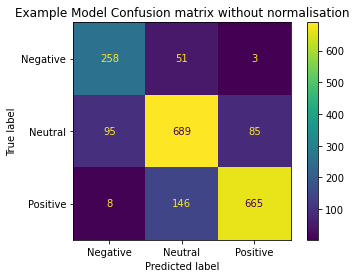

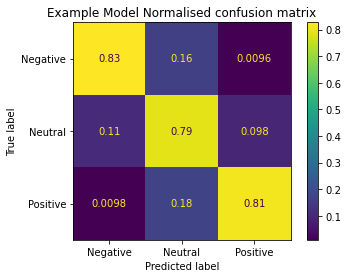

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

titles_options = [("Example Model Confusion matrix without normalisation", None),
                  ("Example Model Normalised confusion matrix", 'true')]
display_labels = ['Negative','Neutral','Positive']
labels = [0,1,2]
for title, normalize in titles_options:
  cm = confusion_matrix(v_y, Y_text_predictions, labels=labels, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot()
  disp.ax_.set_title(title)


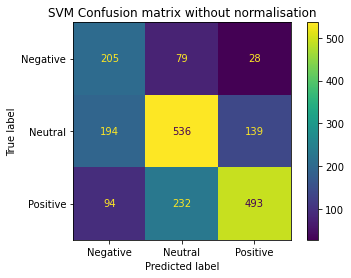

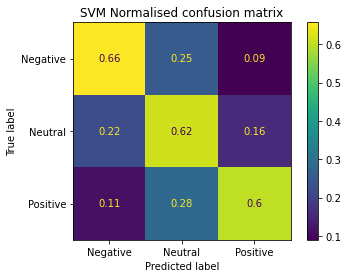

In [12]:
titles_options = [("SVM Confusion matrix without normalisation", None),
                  ("SVM Normalised confusion matrix", 'true')]
display_labels = ['Negative','Neutral','Positive']
labels = [0,1,2]
for title, normalize in titles_options:
  cm = confusion_matrix(v_y, Y_text_predictions_SVM, labels=labels, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot()
  disp.ax_.set_title(title)


In [13]:
# Find misclassfied tweets
error_labels = []
error_tweets = []

for i, tweet in enumerate(v_y):
    if (v_y[i] != Y_text_predictions[i]):
        error_labels.append(Y_text_predictions[i])
        error_tweets.append(v_x[i])

#Write to file
f = open("./data/error_tweets.txt", "w+")
for line in error_tweets:
    f.writelines(str(line))
f.close()

g = open("./data/error_labels.txt", "w+")
for line in error_labels:
    g.writelines(str(line))
g.close()

@user @user @user @user @user ok thank you Curtis, mum is away Saturday but Ella &amp; Owen 
are here all wk end" 
 1 2

"Her is a Chevy Spark in Dons favorite color.  I may joke, but this color sells out as soon 
as the dealer gets... 
 2 1

@user I'm right in thinking you're at Whooverville in Derby on September 3rd aren't I? If so 
I'll see you there :) x 
 1 2

"this may be the one time, i'm disappointed Ye is performing at a show on such short 
notice...thanks a lot Frank Ocean." 
 1 0

@user   Suge is right, that movie is exaggerated. It's almost like Ice Cube wrote the 
screenplay, just like he wrote Friday by himself." 
 0 1

Shammi Kapoor funeral on Monday as tirbutes pour in - Channel NewsAsia: Known as the Elvis 
Presley... #ElvisPresley 
 0 1

@user @user perhaps Russia doesn't want to alienate Israel&amp;its mafias, but then they may 
lose huge opportunities with Iran in future" 
 1 0

Shorty with the wolf pussy off Friday After Next on Martin 
 1 0

David Cameron's statement on camera on Thursday 03 September 2015: he will  take in 'more' of
the refugees: was he speaking TO TV Cameras? 
 0 1

"But Justin Bieber may be, but her real taste if you call _catching him._ It will always 
remain-- ""Your promise to hope for" 
 2 1

Don;t forget to go the CVS tomorrow and get the Viagara. We both know you need all the 
encouragement you can get!!!Dreams and Visions boo:( 
 1 2

I have a ticket for sale to Ed Sheeran's Melbourne concert on the 6th of December if anyone 
is interested or knows anyone who wants one? :) 
 1 2

"Two cans of Red Bull may give you x-ray vision, but five cans give you the ability to hear 
oxygen." 
 2 1

You lot may want to mute or unfollow for the next goodness knows how long this Apple event is
going to last.  I fear a rant may come on. 
 1 0

"FRIDAY Get out of the cold &amp; join us at Rum Runners in Dennisport, 9pm. Then bundle up 
SATURDAY and join George &amp;... 
 2 1

I have an issue driving slow. So im gonna try to make it from AZ to LV in 3 hrs. Tomorrow. 
 1 0

Tomorrow @ 5pm in GSC buy tickets to Ed Sheeran in concert at Riverbend on 9/17. Tickets are 
$20 cash. See you there! 
 2 1

Presidency: Military may wipe out Boko Haram insurgents ahead deadline: The Nigeria military 
could wipe the in... 
 2 1

"Five weeks of intense rehearsals almost complete! Last rehearsal day tomorrow before the 
JBSA cast travels to Singapore! \""Take a bow!!" 
 2 1

@user @user If it\u2019s the Iowa vs. Indiana game\u002c we may be the only two there! 
#TicketsAreProbablyFree 
 1 2

I just want tomorrow to be here so I can see Jurassic World again 
 1 2

I just offered to bring someone Taco Bell for lunch tomorrow & they denied me #WhoDoesThat!? 
You should always accept Taco Bell! #Always 
 0 1

@user noooo like he sang that song! The 1st op of naruto! 
 2 1

If you're coming to Snoop Dogg this Saturday, please screenshot your receipt. If it's 
purchased today, YOU GET... 
 2 1

Take Welbeck being unable for the Euros with a pinch of salt. Pretty sure we'll see him in an
Arsenal shirt come May. 
 2 1

In this second time I've watched Ant-Man and this time I was the only one that stayed for the
2nd after credits scene 
 1 2

when I go to the Foo Fighters concert in October in Atlanta I'm gonna be so sad if don't get 
to meet Dave Grohl somehow 
 1 0

@user 3rd party logic dictates: "That if it makes too much sense and a Nintendo platform is 
involved, it's simply not worth it!" 
 1 0

@user come party with us tomorrow night in Naples Maine at Ricks cafe!! 
 1 2

We always mess up when we get the chance to go up the table when Atleti or Barca mess up. 
PLEASE WIN TOMORROW :) @user 
 2 1

date: august 11th still no sign of frank ocean's new album. the world is turning on itself. 
buildings are burning. god refuses to comment. 
 1 0

I'm going to research this John Kasich fellow tomorrow. He has my attention. 
 1 2

UK: Chancellor Osborne try to sneak into 1st class train with standard ticket   - Breaking 
News Buzz 
 0 1

Will this really be it for Mayweather?: LAS VEGAS: Floyd Mayweather says he will call it 
quits after Saturday'... 
 2 1

Wth am i supposed to do with my Thursday night with no Grey\u2019s nor Scandal?! 
 1 0

@user Olivia and I were so confused Curtis was going to be THE move tomorrow 
 0 1

"Kevin Sullivan talks about nWo ceding power to Hulk Hogan, Greg Valentine accidentally 
knocking himself out and more! 
 2 1

Not to be overlooked by Sandy\u002c a summery mid-upper 70s with sunshine today in CNY. 
Record high of 79 set in Buffalo. More warmth Friday! 
 1 2

"In the history of Tae Kwon Do, Chuck Norris was the first person from the West to be ranked 
a 8th Degree Black Belt Grand Master." 
 2 1

Ebola nurse may have been sick before taking the plane 
 1 0

With a 2nd-rd TKO, Conor McGregor backed up the talk vs Chad Mendes &amp; won the interim 
featherweight title at #UFC189. 
 2 1

Wondering About Carly Fiorina on the 2nd Amendment? Wonder No More. Trump has supported gun 
control. #Carly4President 
 2 1

I've said all along and still staunchly maintain that the Paris attacks: Charlie Hebdo and 
the 13 November 2015 one were both Gladio style 
 0 1

Peru Wants 1D World Tour let's go trending trending trending till we see the sun 
 1 2

I am tweeting this video I found as a tribute to George Harrison because today is the 14th 
anniversary of his death: 
 2 1

"Tomorrow's Charlie Hebdo:  ""They have weapons. Screw them, we have champagne!""  The spirit
of the French is strong. 
 2 1

Do you guys remember that not too long ago Nicki was like one of the most hated artist.. 
During her Pink Friday album 
 1 0

"Judging by the traffic and complaining, I think I might be best setting for Foo Fighters' 
Milton Keynes gig tomorrow right now" 
 0 1

2017 Afcon qualifier: Leon Balogun major doubt for Tanzania: Super Eagles right-back Leon 
Balogun sat out the ... 
 1 0

Chris Brown is me when me and my girl on good terms and that dude in blue in the back is when
we're not  
 2 1

21 to go for Alex Smith! #49ers MT @user Tom Brady wins AFC player of the week for the 22nd 
time in his career\u002c tying Peyton Manning. 
 1 2

Texas is the Walk-Off State tonight. Josh Hamilton just singled in winner in 9th vs Yankees. 
 2 1

@user nobody wants to see you panting in the shadows over Magic Mike XXL at 2pm on a Monday. 
 1 0

"Ant-Man premieres tomorrow night in Doha. A savior from the atrocity that was ""Pixels.""" 
 2 1

I hope Kanye West is the lead on the 3rd season of true detective. Because this script is 
writing itself. #MTVVMAs 
 2 1

@user @user michael ball is incredible 10th anniversary with him and colm is sick 
 0 2

@user Front row shot of David Wright on Wednesday night in St.Lucie. Keep up the excellent 
work, sir! 
 1 2

@user yea I went to the one at MetLife on August 5th #OTRAMETLIFE 
 1 2

"Zayn dedicated his 1st solo award to the boys &amp; the boys' to Zayn :"")  
#5monthswithoutzayn #MTVHottest One Direction 
 2 1

Iran-Backed Houthis in Yemen Fire Missile Into Saudi Arabia: A missile fired from Yemen 
Saturday struck the Sa...  
 0 1

"Hey, can you set up Apple TV so I can watch Harry Potter while I get fucked up?" --ladies 
and gentlemen, may I introduce you to my roomies! 
 0 1

Saudi voters elect 20 women candidates for the 1st time: Two women were elected in Saudi 
Arabia's most conserv... 
 2 1

Joel Obi  may miss out of the Super Eagles team to play Tanzania as reports from Torino say 
he will undergo more tests on a thigh complaint 
 1 0

One of Android fans' biggest fears about the Galaxy Note 5 may be unfounded * 52 
 2 1

@user he waited to long with lennox he should of finished him\u002c both Klitschko\u2019s 
seem to wait till the 6th and 7th round to finish people 
 1 0

"RT @user Went looting in Spurs last night, broke into the White Hart Lane cabinet, so left 
with a pile of dust and a Gareth B ..." 
 1 0

All my coworkers go to Brookwood. That\u2019s the only reason I may go to the game! 
 1 2

'David Price' appeared on Tuesday 4 at the 6th place in the Top20 of Ottawa's Trends: #trndnl
 2 1

THE SUNDAY DAILY The Rock: Hulk Hogan's paid the price for racist rant: DWAYNE 'The Rock' 
Johnson (pix)... #PrkDR 
 2 1

Sam smith tomorrow with my little sister sure why not. LOL 
 2 1

When you remember Nash's new video with Skylynn is tomorrow 
 2 1

"Well, @user may be happy that Thor is hosting SNL, but I'm looking forward to Chance the 
Rapper." 
 1 2

Im not watching them because the Red Sox vs Yankees game is on tonight for who's in first. 
 1 0

People are researching the Wolf crash to try and make SC racing safer. If anyone found his 
GoPro contact Me or Brian Sperry. It may help. 
 0 1

The sun had now completely risen\u002c and the whole facade of Granite House became 
illuminated by its rays; but in the interior as well as on t 
 1 2

@user "We are the 1st generation 2 feel the impact of climate change &amp; the last that can 
do something about it" Obama 
 2 1

Federer beats Murray 6-4, 7-6(6) to reach #CincyTennis final. He'll be going for his 7th 
title vs Novak Djokovic, who is going for his first 
 2 1

I'm not ready for this 5th album. I wasn't even able to handle Niall and Louis and Liam's 
tweets yesterday about the rumors 
 1 0

Do I go to the Colombia game on Wednesday to see James Rodriguez.... #nah #fuckzuniga 
 1 0

Men\u2019s Club Basketball game AT GONZAGA in the Rudolph Fitness Center Court 1 on 
Monday\u002c November 5th at 8:15pm!!! Spread the word people! 
 2 1

Chargers may go 8-8 but that will make playoffs in AFC... NFC teams must win 10 games! Fact! 
@user @user @user @user 
 1 2

My background on my phone is this totally hot pic of Jennifer Aniston when she was like in 
the 3rd or 4th season of friends. 
 1 2

Hey @user please RT, running GNR on Sunday, anyone got suggestions for good running songs.  
Need to update the iPod. 
 2 1

Liberal group tags Bobby Jindal as 'anchor baby' pants on fire,both citizens before he was 21
 1 0

Northern Ireland 1-0 England: The night Windsor Park blew David Beckham away: In the 
aftermath maybe, just may... 
 2 1

I think I may have spent too much on Carmelo Anthony. I only hope that his thick-framed black
glasses will console me in the post-season. 
 0 1

@user @user Yahweh willing, may all the Jews of the world reunite in Israel and find their 
stay. Jewry migration today." 
 2 1

@user Saw him in indy with Eric Church, Brantley &amp; others. 1st act started @user and 
kenny started around 9. 
 2 1

"Today is My Birthday,the anniversary of the death of Elvis Presley and the birthday of 
Madonna,I wonder if I'll be famous...I=No Talent |=" 
 0 1

"I just noticed that Alli Simpson, Sarah, and April follow me. WHY DIDN'T I KNOW HOLY FUDGING
FUDGE BALLS. THIS WORLDDDDDDD" 
 2 0

@user @user Hehe...yeah. I mean it wasn't really really bad, but it got no real attention. As
far as Kpop goes, people may" 
 0 1

Lets be real even wit are D injured\u002c Flacco fuckin up\u002c doin bad on the road\u002c &
are D playin like shit WE STILL 2nd best team in AFC #Ravens 
 1 0

haha \u002c am not going to volleyball tomorrow morning . #NeedMySleep 
 1 0

Man c'mon Nintendo we could get a Mega Man helmet in Splatoon with the amiibo just DO IT 
 1 2

If you don't think I'm the type of person to see Magic Mike XXL alone, on a Monday night, and
get a glass of wine in a solo cup, then... 
 2 1

The Cab is playing on XM and I may or may not have just started flailing. 
 2 1

We get a 2nd Christmas in February with Kendrick and Coles collab album 
 2 1

#AnDy_x9 Revised Expectations for Arsenal After 1st Month of Season: At the outset of the 
2015/16 sea... #AnDy_x9 
 2 1

guysss is it true that selena's album is gonna be released on november 24th omggg 
 2 1

Caitlyn Jenner and her son Brody had some kind words to say about one another as The Hills 
star celebrated his 32nd birthday on Friday. 
 1 2

The Tigers may be calling up Matt Boyd: He's pitcher number two they received in the David 
Price deal.  
 2 1

I want a 16th birthday like My Super Psycho Sweet 16 with extra pyscho. 
 1 2

@user  I just read your Janet Jackson article No Sleeep hit #1 on the R&amp;B Billboard 
Charts and her Unbreakable CD release date is Oct 1 
 1 2

@user It was a Article saying that Zayn is regretting leaving 1 direction pretty much bashing
Zayn like the SUN Always does 
 0 1

Fans were in for quite the surprise at the FYF Festival in LA on Saturday. After Frank Ocean 
c... #HollywoodDivas 
 1 2

@user i thought Meteor Goliath was supposed to be available to everyone today (3rd of 
September 2015) i cant find it im on PS4 
 1 0

@user When's your birthday again ? Mines at the very end of the month the 29th. I order Janet
Jackson tickets last night 
 1 2

I may never tweet about anything other than Kanye West ever again 
 2 0

It\u2019s Tuesday night in Athens! AKA karaoke night at the Volstead so come see me!! 
 2 1

Why do y'all want Nicki to be pregnant so bad like maybe around the 7th album but she's 
literally still in her prime. 
 1 0

Samajwadi Party may patch up with Trinamool Congress: SP sources affirm that party chief 
Mulayam Singh Yadav is likely to patch up wi... 
 2 1

"\""Why America May Go To Hell\""- wish it wouldve been completed and i wish i could read the
contents of it...  by MLK" 
 2 1

@user I love Israel. Love the Jews. So I may make a terrible Nazi. :(   @user @user @user 
 2 0

So .... Who's up for seeing Ant-Man with me on Saturday? 2:30pm showing. Let me know! 
 1 2

"1st Prize.RM 5000 with 4 x Ipad 2 (each person) Trophy, & certificate of participation. 
Lulz, Wanna Joinnnnnnnnnnnnn -___-" 
 2 1

"Sir Terry Leahy, the man behind Tesco's success, is speaking at @user in WGC tomorrow: 
 1 2

@user in the words of Dr. King\u002c \""I may not get there with you\u002c but I want you to 
know we as a people will get there\""" 
 2 1

@user I never once thought, it would be Kane until the last hr. people starting it may be 
Kane." 
 2 1

Palace warns of 'Commoners dangerously close to Prince George. May Discover he's just human 
 1 0

v sad bc a bunch of people are meeting Shawn in San Diego and I'm laying in my couch watching
the day after tomorrow in Spanish 
 1 0

Pope concelebrates Mass with Armenian Patriarch: History was made on Monday when Pope Francis
concelebrated mo... 
 2 1

Here's Shawn's 2nd pass of the day which put us in the 10th spot.  Still have 2 more 
Qualifying Passes today. 
 2 1

@user @user @user Quote of the night- If I were Amarosa I would go to Brooklyn bridge and be 
drowning myself #funny 
 2 1

@user @user Going to be at the Lane on Saturday and if he's not in the squad I'll be 
gutted... Kane needs help! 
 1 0

Last Saturday\u2019s London Children\u2019s Book Swap went swimmingly! see pictures here and 
read about it on the blog:... 
 1 2

Where will Arsenal finish this season? 4th. 36% of voters agree with me. 
 2 1

@user can you please make Big Brother available at its normal time next Thursday (online or 
on another channel)?  Thank you. 
 1 2

"We are going to take 1st place, keep voting!! #MTVStars Lady Gaga 
 1 2

@user we want you to milan tomorrow !!! 
 1 2

"\""""men tomorrow you will have one of your hardest patrols...CIF turn in\"""" lets hope i 
have everything" 
 0 1

"Brock Lesnar confronts The Undertaker: Raw, July 20, 2015 via @user This is what we call the
WWE B| HELL YEAH!" 
 2 1

West Indies to pull off from the India tour after the 4th ODI in Dharamsala owing to pay 
dispute with their Board. 
 0 1

Kanye West is insane. He also may be a complete genius. But I still don't want him to be 
president. #VMAs #fb 
 1 0

"Ok sir RT @user Nigeria will still top the group.If we lose,we'll be 2nd & face Brazil. 
(cont) 
 2 1

Come see us at the Scottsdale Home & Garden Show on Nov 3rd & 4th at Westworld of Scottsdale.
Be the FIRST to see the new holiday items! 
 1 2

@user All you need to do is catch U2 to Brunel University looool in shaa Allah man, I'm free 
atm. I start in October" 
 2 1

"#AFailedTextFromToday """"You going to Soundset?""""-Name Withheld. """"Uh, Soundset was 
last Sunday...."""" Ahahahaha" 
 0 1

Watching the 2nd punisher. Wish they\u2019d make another one with Quentin Tarentino directing
and Thomas Jane as Castle 
 2 1

Got tomorrow off, not going to digi tonight would be rude 
 2 0

Really hope Chelsea start Baba instead of Ivanovic on Saturday, he's literally aged about 5 
years over the summer 
 0 1

"Triple H was never Ric Flair's bitch...this Sunday I'm gonna make you mine!!!"  - John Cena 
#Raw #TitleforTitle #JohnCena  #Truth 
 2 1

Is anyone else reading that Zayn may be performing at the VMAs with The Weeknd? I'm not 
emotionally ready for that. 
 1 0

With all Benson\u2019s attention\u002c Frankie feels like a forgotten stepchild. Lets 
\u2019founding father\u2019 him so he know we will never forget 2nd place. 
 0 1

Big whoop--it's Beyonce's birthday. My birthday's coming (Sept 13) and I bring just as joy to
people 
 1 2

"I guess with DJ it's a Sunday thing and not a final round thing, and Paul Dunne? Are you 
kidding me? #OpenChampionship" 
 0 1

@user Heh, that's my line. I'll post some @user here tonight to protect it, then tomorrow 
we'll let Twilight inspect it." 
 2 1

"i should get all my sh*t done tonight so i can go to the like, gay club tomorrow and try to 
find FRIENDS but... but..." 
 1 0

@user I just rewatched the whole first season, for the 2nd time! This is blasphemy! In the 
words of U2 ""I feel numb"" #Hindsight" 
 1 0

@user going to Florida with the fam, I'ma be back Tuesday tho. don't trash the room up too 
much! lol." 
 2 1

Here's the AM message form PFBC this Sunday for those away for Labor Day..."Web of Lies" in 
Acts 5:6-11 via @user 
 2 1

What's stopping Jay-Z, Puffy, 50 Cent, Lil Wayne from doing the same if they haven't already?
@user  
 0 1

@user calibraska is 7th in Italy but no one can hear it because of the 'explicit' 
#CalibraskaEP 
 1 0

Jeb Bush fading from the presidential race and Hillary Clinton slowly dropping from the 30th 
mark in the presidential race.....  Obvious! 
 1 0

@user KL Live is REALLY COMPACT. My friend went for Beast's 1st showcase and it is REALLY 
squashy. Just a heads up. 
 1 0

@user  Listening to the album right now \u002c for the 20th time lol \u002c I\u2019m on 
Poetic Justice now 
 2 1

I can't believe I saw Ed Sheeran front fucking row at fucking red rocks and then the 2nd 
night I snuck in and saw him 5th row 
 2 0

I'm getting strong mail that Eden Hazard will become a Roo tomorrow. Pick 39 & Garlett to 
wherever the f*ck Hazard plays soccer. Good deal 
 2 1

@user MaxPreps photographer Jace Kessler will be on the sidelines tomorrow nite covering your
Var Football game vs Ventura! 
 2 1

Just put Twilight on then realised what had done and now I'm sat on my stairs thinking about 
my actions. 
 1 0

@user @user Haha we're off round Claytons now then the Rising Sun later! 
 1 2

Lord Sugar named best business role model in the UK + Kim Kardashian came 3rd as voted by 
students. Was Santa 2nd? 
 1 2

@user @user Don't feel obliged to discuss #Dexter tonight. Living it large in Brighton so 
please use direct messages.... 
 2 1

Liverpool flop Mario Balotelli delivers remarkable Real Madrid SNUB with Barcelona JOKE: 
Mar... ff @user 
 1 2

Dustin Johnson hasn't recovered since Saturday at the Open Championship. Absolute head case 
right now 
 1 0

@user No jack!! went on Rita last Sunday... And I swear I\u2019ve got bruises on my head from
it\u002c it\u2019s TOO fast! My head took a bashing! 
 1 0

Spent Labor Day on the campaign trail in New Hampshire, listening to Bernie Sanders (who I'll
write about Sunday)... 
 1 2

"I'm watching the movie Friday, on a Friday and I'm going to see Ice Cube next Friday 
 2 1

It\u2019s Josh Bradley\u2019s birthday tomorrow. So what time is the party? LOL 
 2 1

@user @user my memory  doesnt have more space. So i cant download it :( but i'll try to 
download it tomorrow from iPad 
 1 0

Digne and Falque caused Juventus real problems down their left in the 1st half. #ASRoma 
#Juventus 
 1 0

ah the tables are now turned &amp; it is *Jon Stewart* who will be the one getting destroyed 
in every news headline tomorrow thanks to John Cena 
 1 0

Amazon Prime Day really was better than Black Friday; I could look at all the crap I didn't 
want from the comfort of my own home. 
 1 2

I need to log off now bc school starts tomorrow and I'm still not done with my summer hw. 
Have a Shawn pic (not mine) 
 1 0

"Thompson, White Sox rally to edge Red Sox: Trayce Thompson was 3-for-4 with 3 RBI Tuesday 
night while li... #news" 
 2 1

I'm going to miss so many broadcast at Digi tomorrow because of this dm an tournament 
 1 0

About last night: Kris Bryant wins a wild one with walk-off home run in the 9th. #Cubs 
photos: 
 2 1

"ABC: Giant pandas may be cute, but it takes a lot of work to support their lives in 
captivity: 
 1 0

Gonna watch Final Destination 5 tonight. I always leave the theater so afraid of everything. 
No huge escalators for sure :S 
 1 0

Me prepared for the Fancy Dress Ballroom Party this Sunday, wearing this MASK of BATMAN today
to see how much it... 
 2 1

Not being funny but is it true that Saudi conceded that they got it wrong by declaring Eid on
the Friday ? ..... 
 1 0

When I wake up tomorrow I'll be in a different country. Whoa! I didn't run into a David 
Beckham at the airport. That's a bummer. 
 2 0

I'M SO SERIOUS. January is 5 months away so I thought everyone was talking about Zayn's 
birthday. 
 1 0

Can I just fast forward to the Ed Sheeran concert Saturday 
 2 1

@user thank you sir Jonathan, on another note, Curtis tomorrow with Bryce Quandel and I?" 
 1 2

Was thinking about seeing JAWS at the Roxy on Wednesday\u002c but now it seems I\u2019ll be 
seeing BAIT 3D instead. It\u2019ll be just as good\u002c right? 
 1 2

Phish, August 9th 1998.. the day they covered Grateful Dead's Terrapin Station suite on 
anniversary of Jerry's death 
 2 1

@user may i also remind you Milan  was one the original clubs punished in the scandle 
 0 1

Performing with black artist doesn't take away the fact that Nicki gave you a 3rd degree burn
with her tea hunty.  
 1 0

Josh Hamilton the best 1st pitch player in baseball gets a slow hanging curveball down the 
middle &amp; just looks at it. Lol 
 1 2

Disappointed the Knicks vs Nets game got canceled tonight\u002c but I\u2019m even more hyped 
for Knicks vs Heat on Friday! 
 0 2

if Selena will release the single next Monday with Taylor's new song she can kiss #1 on 
iTunes goodbye 
 0 1

I could be going to digi tomorrow but I thought I was supposed to be seeing the girls but 
they cancelled lmao 
 1 0

Sept 17 video chat: running DevOps in hybrid cloud with @user and IBM experts. 
 1 2

@user I honestly find it difficult to imagine a reader not knowing that Watchman was a 1st 
attempt with serious issues. 
 1 0

@user WAIT WHAT?!?! SCOTUS makes laws!?!? since when? have i been lied to my entire 8th grade
year about gov? (sarcasm intended) 
 1 0

Life is so difficult; especially when you need to decide to spend money on dorm stuff or if 
you want to buy chick-fil-a and dunkin tomorrow 
 1 0

Interested to see what kind of ratings the U.S. Open final gets on Saturday with Serena 
presumably going for history up against CFB. 
 2 1

@user I'm from Halifax, Nova Scotia. Not sure if we will go on March break, I'll have to see 
as it gets closer. Why?" 
 0 1

"Leo eyes record, Barca seek boost: In the week that he marked the 10th anniversary of his 
competitive... #femnath" 
 2 1

I just found that Barcelona and Real Madrid are playing on Sunday... I need sleeping pills...
 1 0

I'm just sat here waiting for work to come around and Jimmy's at the Ice Cube q+a and I've 
just missed an opportunity to interview Kurt Vile 
 1 0

"Nigeria's military said Monday it had ""besieged"" Boko Haram positions in the Islamist 
militant group's... 
 2 1

Going to see Paper Towns on Saturday. I'm hoping it does the book justice. 
 1 2

Someone should have told Thor that sun in is just for hair and not for eyebrows 
 0 1

@user is true that you will give two concerts in Mexico City on 01 & October 02, please tell 
me because not enough tickets TE AMO" 
 2 1

"\""""@itsmekatsumi: Cupid doesn\u2019t lie but you won\u2019t know unless you give it a 
try\"""" wwooww.may pinaghuhugutan!" 
 2 1

@user how about you &amp; I go see Janet Jackson in Dallas for her Unbreakable tour Jan. 24? 
 1 2

Relatives of the 200 Nigerian schoolgirls kidnapped by Boko Haram will hold a march &amp; 
candle-lit vigil to mark 500 days since the abductions 
 2 1

@user Look at SPX daily in early June 2012. It bottomed the day after SPX 200d SMA was 
sliced. This time, 200d was sliced yesterday." 
 0 1

Sunday World Man charged with IRA membership granted bail 
 0 1

On November 18th 1998, Nintendo released the Game Boy Color. The first handheld allowed to be
owned by POC. #BullshitHistory 
 2 1

"If John Cena is really behind the WWE keeping the belt on Nikki, I may not be in love with 
him anymore." 
 1 0

Finished season 3 of the league and am now finally watching Act Of Valor. Operation lazy 
Saturday night nearing completion. 
 1 2

Chuck Norris wears sun glasses to protect the sun from his eyes. 
 2 1

@user I hope someone asks Harper why the team bailed in the 7th inning 
 0 1

Christians News Christian Wilhelmsson: How Chippen Will Help the Los Angeles Galaxy May it be
worthy. 
 2 1

PUMPED to open the season tomorrow night against Georgetown!  Women\u2019s Preview: | 
Men\u2019s Preview: 
 2 1

"Team CK vs Demolition on November 17th at the American Legion Post 80, Main St. in 
Binghamton NY. Get your tickets now! 
 2 1

@user if you're interested... Mansbridge's Harper interview. Justin tomorrow, Mulcair 
Wednesday. 
 2 1

going to kms because I didn't check fantasy before thursday and left arian foster on my 
bench... he got 25 points 
 2 1

@user I was there for Charlie Hebdo. My sister is going there Dec 2 so I'm updating all my 
followers on FB. Mom's ok. For now. 
 1 2

Todays #ullukapatha is Rahul Gandhi . You may ask WHY ? Nothing . Just that he is a filler on
days we have no Ullukapathas . Happy Diwali 
 2 1

PM ready for reply on coal blocks: Congress: New Delhi\u002c Aug 22 (IANS) With the Bharatiya
Janata Party (BJP)... 
 2 1

the thing I'm most jealous of ab Miley is that she got rapped ab by Jay...nearly marrying 
Liam is a close 2nd 
 2 0

@user Friday\u2019s the main day!!!! Knicks vs Heat 
 2 1

It looks like Nokia may be positioning for a strong return to the mobile hardware market 
following a license with...https://t.co/k2q1uKd0eT 
 1 2

@user ok big diff lmao my parents were boaters they didn't know a lot abt Islam when they 
came. My oldest sis wore it in 1st 
 1 0

"LMAO RT @user Went looting in Spurs last night, broke into the White Hart Lane cabinet so 
left with a pile of dust and a Bale DVD" 
 1 0

May be the only person around here who really doesn't like bdubs or Eric church. 
 1 0

I will never look at Michelle Obama the same way. My sides will be sore tomorrow... Worth 
breaking the Internet for! @user 
 1 0

"I'm about to start barging The Pier every monday, imma just need to stock up on Moebius 
stickers" 
 0 1

The safest place to be in Tottenham tonight is the Spurs trophy cabinet. There's no chance of
looters visiting there. #gooners #goonerpower 
 2 1

"Appointment with Barracuda in Milan, from 1 to 4 September. [Pav. 3 Stand: G01/H02-H06 ] 
Don't miss the event! 
 1 2

"on Black Friday i always thought Kendrick said ""Coney Island!!"" but he says ""Can you 
Handle It"" lmfaooo #whyamistupid" 
 1 0

And then there are those who made a case for Yakub's innocence or his possible reform if he 
wasn't hanged. 
 0 1

@user @user @user I never touched it so it was obviously Tor, bloody hell Gazza we'l get 
another one Saturday! Xx" 
 1 0

Almost 3M between Bey and us! We have to vote harder to take the 1st place Monsters! 
#MTVStarOf2015 Lady Gaga 
 2 1

Jay-Z sat in that Interview like a God showing that he was truly ahead of his time while the 
other niggas flirting with Foxy Brown 
 2 1

Three times Grammy nominated\u002c Brit Award nominee and Ivor Novella winner Joan 
Armatrading takes to the stage on Sunday! 
 2 1

@user I liked the 4th sentence about the "LA Galaxy where David Beckham was put out to 
grass..." 
 1 2

"Kapan sih lo ngebuktiin,jan ngomong doang Susah Susah.usaha Aja blm udh nyerah,inget.if you 
never try you'll never know.cowok kok gentle bgt" 
 0 1

it\u2019s ages since I had KFC\u002c well apart from the mush in a bun that passed as 
breakfast last SUnday\u002c that doesn\u2019t count though 
 0 1

"Cant wait to watch the debate tomorrow night. If Romney grills Obama as hard as he did 
Gingrich in FL, Romney will wipe the floor with Obama" 
 2 1

Serena beat sister, Venus Willaims, 6-2, 1-6, 6-3,to continue her march to the calendar Grand
Slam at the @user 
 2 1

Christians should be the most happy and cheerful people... so others may say 'what makes him 
so happy?   #Saved #Happy #StraightOuttaOfSin 
 1 2

"So the 18th will the best weekend, Jason Aldean and @user @user @user @user #BGBOUND" 
 1 2

Looks like BJ\u2019s Skate Center is the place to be in St Joe on a friday night! 
 1 2

@user if Jordan Spieth or Dustin Johnson can be the LeBron of golf, I may watch in a few 
years. I want to see dominance in golf." 
 1 2

Big Brother starting next Friday? At the end of this morning @user slipped up &amp; said 
'don't cause you'll get me sacked before Friday night 
 1 0

I have a huge midterm tomorrow so I was listening to Iron Maiden to help with my anxiety but 
now I just wanna watch Game of Thrones :/ 
 2 1

From my recently viewed list I can see my Dad watched the entire 1st season of Gilmore Girls 
on Netflix yesterday #Dale 
 1 2

My family &amp; I flew from Israel for 14 hours and our 2nd flight was delayed one day. we 
were only an hour away from home #delightdelaysweeps 
 0 1

@user this is absolutely ridiculous. Wasn't it just ""national ice cream day"" on Sunday? Who
makes up these days? This isn't official. This is" 
 1 0

Monday Night Raw is on on Monday nights from 7pm-10pm. The 3rd season of Teen Mom 2 is on a 
new night. Mondays. At 9pm. Oh the dilemma...... 
 0 1

"George Lincoln Rockwell was one of the 1st to recognize that Conservatives like @user 
Buckley, Goldwater &amp; Reagan were #Cucks for Israel." 
 0 1

I may have just mentally assembled the most insane conspiracy web about the Dr. Luke / Kesha 
sitch. 
 1 0

Sorry for the lack of Minecraft my computer is broke so I can't play it on PC. May try to 
record Xbox 360 Minecraft till I get a new one. 
 1 0

@user you may recall the other day I said nothing could save your holiday after that 
t-shirt...Jurassic Park is the only thing that could 
 2 1

"Should Paul Dunne of IRL finish the Open in 8th alone or better, he'll move to #1 in the 
SPWAR.  Same for Niebrugge if 5th alone or better." 
 2 1

I think having Briana be a full-time housewife may be the best thing for the show as she 
would be a good way for the girls to let Vicki back 
 1 2

@user I may just have to watch Sharknado 3 tomorrow haha 
 1 2

Return of Sunday morning watching the lad play footy. All week I picture them playing like 
Barca, the reality is very different. #YouthFooty 
 2 1

Check out the Christmas trading times for the Eagle Farm Markets! Don't miss the Twilight 
Fresh Market on Wednesday! 
 1 2

Monsanto wants to merge with Syngenta and change name to wash away the bad reputation (3rd 
most disliked company!): 
 1 0

KURT COBAIN Masterpiece #MontageOfHeck opens Friday! Filmmaker @user in person for Q&amp;A 
after the 7pm show! 
 2 1

In one weeks time I managed to binge watch the entire 4th season of Gilmore Girls and write 
my Stress management plan/paper #Multitasker 
 1 2

Please. Rousey will make Cyborg her bitch. Too bad Cyborg loves the juice. 
 1 0

Nicki did that for white media Idgaf . Nicki may act like she don't give af but she cares 
what the media thinks 
 2 1

"Spent the morning Xmas fabric shopping, may have taken a detour via @user Xmas shop shhh x 
 2 1

David Price should not have been pitching in the 8th. They can't get a 6-outs from the 
bullpen? Yankees - Jays 
 1 0

Oh and Rafa said before the injury he was having the best year he ever had was 1st in the 
race... :( #M6 
 0 1

"It's $125 for the Seth Rollins meet and greet on Friday. Seth, I love you and all and your 
my favorite wrestler but HELL NO" 
 1 0

Love and Harden hitting the deck in pursuit of loose balls early 2nd Q. Proof this is NOT an 
NBA All-Star Game. 
 1 0

Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond 
 2 1

@user Prayers for all of you today. May God carry each one of you during this sad time 
""Footprints in the Sand"",  RIP Frank Gifford" 
 2 1

"If I do end up going to the concert tomorrow, I'm gonna scream ""cheater"" when Jason Aldean
walks on stage." 
 1 0

\u2019on a sunny Sunday afternoon\u002c it could be quite magical.\u2019 - Designer reveals 
plans for Olympic Park via @user 
 1 2

Is the 20th anniversary PS4 still the coolest special edition console ever? 
 1 2

IRG may be laughing all the way to the bank but USAID has done next to zilch for Pakistani 
power consumers. 
 2 1

Tomorrow morning on Good Morning America... Hulk Hogan ...I cannot say enough about this guy 
and what he has done for so many. 
 1 2

Islam is on the march to convert all to their ideology! Wake up America! #RT #STOPIslam #TCOT
#MakeDCListen #TeaParty 
 1 0

Don\u2019t Forget\u002c tomorrow is the annual General Body meeting! Come out to learn more 
about ISAT and the organizations we are affiliated with! 
 1 2

Soo apparently I've been dared by @user to not talk about the boys or Zayn for a whole day 
tomorrow I can't even rt them or anyth 
 1 0

envy everyone going to the Big Bang shows tomorrow and Saturday. ;_; 
 1 2

it looks like a beautiful night to throw myself off the Brooklyn Bridge ---@Tim_Hecht 
 0 1

"Glenn will personally go to the border to bring in Christians marked for extermination: 
'Last Friday, Glenn pl... 
 1 0

Chelsea will pursue the signing of Paul Pogba from Juventus until the transfer window closes 
on Tuesday. (Source: Independent) 
 2 1

Just watched The Lorax for the 20TH TIME!! #ihavenoregrets #OOC 
 1 2

Shawn will be at the VMAs tomorrow and I'll be at the red carpet so ill be updating myself 
 2 1

Bwahahaha what's going on with March Against Monsanto lately? They claim to know their 
"research" yet have... 
 1 0

@user psst, can you take Oracle of the Sun and put that one sun on it's chest? I know Cyd 
would "love" it. 
 1 2

Yakub has gone. whatever happened may be right. I want asked Kiran bedi .that whatever Yakub 
done.it was wrong  but after Babri masjid -- 
 0 1

tom brady supports Donald trump. Therefore he's gonna throw 4 pics and pull his hamstring on 
Thursday night. 
 1 0

Harper's Worst Offense against Refugees may be Climate Record as rising temperatures add to 
chaos in the Middle East 
 1 0

Still in search of the really Dayna Santullo. She's been missing since she willingly passed 
on a Chris Brown concert on Saturday 
 0 1

"C'mon, you guys can do better than this. Don't look down on KPOP.....  
 1 2

"St Pattys is no big deal for me, no fucks are given, but Cinco De Mayo on the other hand .. 
thats my 2nd bday ." 
 0 1

@user they go to a different place for brunch every Saturday. They started the tradition with
IHOP 
 1 2

chris brown and august alsina sang hold you down and all i could think about was jungkook 
singing it and i almost cried 
 1 2

For the sake of being at work during th Miss USA finals I am deleting my Facebook app until 
tomorrow so I can... 
 1 0

When you're leaving Saturday but your cousin offers you an extra Foo Fighters ticket... 
 2 1

@user tom Brady did not deflate balls, but was suspended for 4 games bc he may or may not 
have known it was being done" 
 0 1

@user @user Dear CNN thank you for advertising Sarah Palin was going to be on your show 
Sunday morning. I didn't watch. Get wise! 
 1 0

@user like how are ppl supposed to pay rent? Should i ask the pope on the 26th when he comes?
 0 1

"Don?t worry, console gamers: LawBreakers may still come to the Xbox One, PS4 - 
 2 1

@user @user If it weren't for Blair there would have been no Good Friday Agreement, and the 
IRA would have won!" 
 1 0

"RT @user I can't wait to read all the tweets from all of the girls bitching about being 
single tomorrow! #myfavorite 
 0 2

#PirateGang @ the Rex Theatre tomorrow doors open at 5pm. Come show your support if you fuck 
with real music !!   #Gang 
 2 1

I'm at work for 14.5 hours tomorrow lmao someone make me go to bed and stop reading articles 
about nicki 
 1 0

Eastern Men's lax hosting the MAC Championship on Saturday be there!!! 
 1 2

I may get killed for this but I watched 15 minutes of pretty little liars. The girls acting 
ability is as good as the acting in Sharknado. 
 1 2

"When I'm soaring on Sunday afternoon, I learn Frank Gifford--one of my faves on the field 
and inside the broadcast booth--has died." 
 0 1

"John Kasich may not be terribly polished, but he's coming across as more comfortable and 
real than Jeb Bush. #GOPDebate" 
 1 2

"Tokyo , Seoul , London , New York Kimama Ni Sekai wo drive tonight Kakuchi de hirou suru new
style :)" 
 1 2

Why is Jay Cutler good in the 4th qtr and not others? Good question\u002c ESPN. Could be 
worse\u002c though; he could be Tony Romo. 
 1 0

@user If I'm honest disappointed to hear BBC are covering it, 1st I'd heard, prefer license 
fee money to be spent on domestic sport. 
 1 0

@user I've only got Niall now ... But if you want Harry I'll get more tomorrow!! 
 2 1

Are you using your smart phone or tablet in the late evening? Twilight may be a solution for 
you!  R 
 1 2

@user i could stop by dunkin tomorrow, want anything" 
 2 1

Tomorrow I'll be throwing myself around to Black Noise. Come and do the same at The Horn 
St.Albans from 7:30pm 
 2 1

Jason Aldean being on a Thursday makes me really not want to go 
 1 0

Briana going to Memphis tomorrow w/ bro ham which means I'm leaving too brooklyn Lml I refuse
to stay in boring as jersey by myself 
 1 0

"As she receives her 9th #GoldenGlobes nomination, read what Cate Blanchett told us about 
still getting starstruck: 
 2 1

@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. 
But they may do this time around. 
 0 1

tomorrow I've to wake up  early so Zayn's erformance on VMA better be true otherwise u'll 
regret for playing with my emotions and sleep 
 2 1

why did I just spend the last 30 min rapping my fav Kendrick Lamar songs when I have a 5 page
paper due tomorrow?? 
 1 0

@user Sorry to hear that! If things change before Feb, lemme know! I'll buy you a coffee and 
squee about Kim and Briana at you. *lol*" 
 2 1

@user @user May I just point out that even though DT's tweet was horrendous, it was after 
Charlie Hebdo on January 7th" 
 1 0

#Forbes The NYSE\u002c NASDAQ and the other US stock markets all made a wise decision to take
rain days on Monday and... 
 1 2

Jay Z joins Instagram with nostalgic tribute to Michael Jackson: Jay Z apparently joined 
Instagram on Saturday and.. 
 2 1

"As Sonia &amp; could not buy SC judgement in favor of Yakub, they are worried that Teesta 
and Tejpal may have to face the same fate." 
 1 0

Who wants tickets to Wednesday night's Dress Rehearsal of Aida at Winspear Opera House? Be 
one of the first 6 to... 
 2 1

If I celebrate it wrong will Thor beat me with his hammer? 
 1 0

As long as it's not Chris Evans standing in!!!! 
 2 1

I drew a fairy King on - with David Bowie pants and all. hope to see everyone on Saturday :D 
 1 2

Just got told I look like Sam smith for the 22nd time 
 2 1

Purples and Football at Baby A's with my Aunt and Cousin. ready to see my JETS play on monday
;) 
 1 2

"Rahul Gandhi is a ppl's leader. ModiMafia may try as hard, they will not be able defeat him 
simply becuz ppl's voice just cannot be curbed." 
 2 1

March with @user in Cleveland's Pride Parade tomorrow.  
 1 2

I found my old ipod classic from the 5th grade the songs on it oh my god 
 1 2

Hope the Pope heard about it  
 2 1

Honestly the only reason I wanted to go to the Keely Chesney concert tomorrow is to see Eric 
Church and Brantley Gilbert 
 1 2

If my The Vamps exclusive @user album isn't ready for pick up today like it says I will riot!
Been waiting since Dec 4 for it 
 1 0

"Nicki is FED UP! When she 1st came out she was bashed for her creativity, her body, her 
music. Now her opinions. I don't blame her." 
 1 0

"Frank Gifford may have been a very nice man! But, he cheated on Kathy Lee with a woman who 
videotaped the incident!" 
 1 0

"Text from my dad: \""""you like Charles Dickens\"""" 1) obvs looking at my amazon wish list 
(too late for Sunday) 2) why th surprise?!" 
 2 1

When girls become bandwagon fans of the Packers because of Harry.   Do y'all even know who 
Aaron Rodgers is?  Or what a 1st down is? 
 0 1

"I really just tweet on Wednesday ,Thursday and Sunday because of Big Brother but other then 
that I don't tweet now." 
 2 1

You may want to plan on getting a cup of coffee at Winans this Saturday! 
 1 2

@user forget the yankees.. Brock Lesnar in the ring on Monday night RAW! 6 days to summer 
slam! 
 2 1

UCLA Study Shows Why One of the Biggest Obamacare Fears May Not Come To Pass - California 
Healthline 
 1 0

Tbt to tik tok by kesha... That shit was the knock in 6th grade 
 2 0

"The Night Watchman's Journal.... Scholar Who Walks the Night... poor you sun, homin oppas do
not like u.. they like night more" 
 1 0

"i got lots of tweets asking for shoutouts to Niall, if i think about it i will give 
shoutouts to Niall when i get back from work TOMORROW!!" 
 2 1

"Roskilde Festival starts today.Tomorrow Jakob Bro+Thomas Knak will introduce their music 
""""Bro/Knak"""" live for the first time @user 
 2 1

Justin on the 17th place? Where are the believers at? #MTVSTARS Lady Gaga 
 0 1

I want to trade an Ant-Man fig for this Yellowjacket. All from @user June box. Tweet if 
interested 
 2 1

Eden Hazard's pass for Mata's 2nd goal yesterday was an absolute dream. Had the watch it 
about 5 times to believe it. #worldie 
 1 2

Tomorrow I will either stream, more Max: The Curse of Brotherhood, Minecraft, Trials Fusion, 
or Call of Duty: Advanced Warfare, you tell me. 
 2 1

Nicki better release a raunchy vid for trini Dem girls so it can get her 1st grammy 
 2 1

Grand opening tomorrow. Come out to Vans at Town Center and visit me and check it out! 
 1 2

#Nats Rendon bunts but Werth is erased at 2nd. Runner on 1st with 1 out.  Harper at bat... 
 2 1

"Ooh Operation Raccoon City is 19.99, I may pick that game up, if I have the strength to..man
I gotta sleep earlier." 
 2 1

Calling all voters\u002c I\u2019m calling on Nevada\u002cFlorida\u002cOhio\u002cTuesday night
is the night u guys will i repeat will shine for the president lets go! 
 1 2

My Bernie sanders buttons haven't come in the mail yet and I'm super stressed because I'm 
moving on Sunday. 
 1 0

"I'm going to @user at Fabrique in Milan, Italy - Feb 19 
 2 1

March Against Monsanto founder, Tami Canal, discusses #FoodJustice with Anthony Gucciardi. 
 2 1

I had a dream that Brock Lesnar won the 3rd annual #WMT because he F5d everyone. I woke up 
hoping it wasn't a dream. 
 2 1

Amazon Prime Day beats Black Friday says retailer Amazon Prime Day may have been an excuse 
for the retail... 
 0 1

Last tweet of the night\u002c reading will not lose to spurs tomorrow 
 2 1

"Shazia Ilmi joined BJP's """"Swachh Bharat"""" campaign. Noble intentions or may be the fact
that no woman likes to be ignored for a long time." 
 0 1

"LONDON (AP) "" Prince George celebrates his second birthday on Wednesday and while he's just
a toddler, he's al...  
 1 2

@user @user I think the Red Sox may be more popular around that region as well. Have many 
more fans nationally than Pats 
 1 2

@user nah I'm prolly jus gonna get the Gucci foams that come out on Friday 
 2 1

Did you know that 'Janet Jackson' was Trending Topic on Thursday 3 for 8 hours in Calgary? 
#trndnl 
 2 1

@user tickets are 60 or 114 but I'm getting the 114 oneeeee lol I just need to know who down 
frfr. December 5 at oracle 
 2 1

@user @user Funny how you call it ""Thursday"" and don't believe Thor was real." 
 2 1

"Harper spoke Tuesday on how the Cons will balance their security concerns with more refugees
into Canada". Instigating hate #cdnpoli 
 1 0

The only reason Dustin Johnson didn't play  well is because it's a Sunday.  Luckily for him 
the final round is on Monday.  #TheOpen2015 
 2 1

"I'm still not over Kendrick's ""Black Friday"" freestyle. Lyrically up there with the 
""Control"" verse. I said it." 
 2 1

@user digi was on the 18th but i didn't go but im going to slaybells 
 2 1

#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 
college-bound students at the pentagon office. &gt;&gt; 
 2 1

"just saw a report where forecasters are showing snow for @user neck of the woods on Wed. Oh 
boy!!! 
 0 1

Charles Gets The Grandkids Into Gardening: He may be only two years old but it seems Prince 
George's grandfath... 
 2 1

just bought my 1st Heineken beer in Las Vegas.  ps I\u2019ve lived here for 5 yrs ~what took 
me so long! 
 0 1

"anyone interested in a couple of tickets for Runrig tomorrow at the Northern Meeting Park, 
Inverness?" 
 2 1

Sun 12/06:  Thor the Elf hanging out on our TV this morning. #ThortheElf2015 
 2 1

Barca beats Joventut 86-77 in 1st preseason game. Marc Garcia and Demond Mallet led all 
scorers with 20 points each 
 2 1